In [1]:
#pip install google-cloud-bigquery
#pip install pydata_google_auth
#pip install db-dtypes

In [2]:
#インポート文
import numpy as np
import pandas as pd

import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
from lightgbm import LGBMRanker

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix

import optuna

import pydata_google_auth
from google.cloud import bigquery 

In [3]:
credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
)

In [4]:
client = bigquery.Client(project='keiba-381006', credentials=credentials)

In [5]:
horse_query = '''
    SELECT * 
    FROM horse_dataset.main_horse_table 
    LIMIT 1000
    '''
horse_df = client.query(horse_query).to_dataframe()

In [6]:
race_query = '''
    SELECT * 
    FROM race_dataset.main_race_table 
    LIMIT 1000
    '''
race_df = client.query(race_query).to_dataframe()

In [7]:
# #データのインポート
# race_df = pd.read_csv("../data/main/race_data.csv",parse_dates=['datetime'])
# horse_df = pd.read_csv("../data/main/horse_data.csv")

In [8]:
#データのマージ
race_df_for_merge = race_df[['race_id',
                             "race_round",
                             "race_title",
                             "weather",
                             "ground_status",
                             "where_racecourse",
                             "total_horse_number",
                             "frame_number_first",
                             "horse_number_first",
                             "frame_number_second",
                             "horse_number_second",
                             "frame_number_third",
                             "horse_number_third",
                             "tansyo",
                             "hukusyo_first",
                             "hukusyo_second",
                             "hukusyo_third",
                             "wakuren",
                             "umaren",
                             "wide_1_2",
                             "wide_1_3",
                             "wide_2_3",
                             "umatan",
                             "renhuku3",
                             "rentan3",
                             "is_obstacle",
                             "ground_type",
                             "is_left_right_straight",
                             "distance",
                             "weather_rain",
                             "weather_snow",
                             "datetime"
                            ]]

merged_horse_df = pd.merge(horse_df, race_df_for_merge, on='race_id')

In [9]:
#datetimeをUnix時間に変換してint32に変換する
unix_time = merged_horse_df['datetime'].astype('int64')
unix_time_int32 = unix_time.astype('int32')

merged_horse_df['datetime'] = unix_time_int32

In [10]:
#エンコード
for column in ['race_title',
               'weather',
               'where_racecourse',
               'ground_type',
               'is_left_right_straight']:
    le = LabelEncoder()
    le.fit(merged_horse_df[column])
    merged_horse_df[column] = le.transform(merged_horse_df[column])

In [11]:
#使う特徴量の設定
id = {"race_id",
      "horse_id"
    }

feature = [
#horse_df
           "race_id",#後で抜く
           "horse_id",#後で抜く
#            "rank",#目的変数
    
    
           "frame_number",
           "horse_number",
           "sex_and_age",
           "burden_weight",
           "rider_id",
#            "goal_time",結果なので
#            "goal_time_dif",結果なので
#            "half_way_rank",結果なので
#            "last_time",結果なので
#            "odds",
#            "popular",
           "horse_weight",
           "tamer_id",
#            "owner_id",#テストでできてない
#            "is_down",#テストでできてない
           "is_senba",
           "is_mesu",
           "is_osu",
           "horse_weight_dif",
#            "burden_weight_rate",#テストでできてない
#            "avg_velocity",結果なので

#race_df           
             "race_round",
#              "race_title",タイトルはややこしいので
             "weather",
             "ground_status",
             "where_racecourse",
             "total_horse_number",
#              "frame_number_first",結果なので
#              "horse_number_first",
#              "frame_number_second",
#              "horse_number_second",
#              "frame_number_third",
#              "horse_number_third",
#              "tansyo",
#              "hukusyo_first",
#              "hukusyo_second",
#              "hukusyo_third",
#              "wakuren",
#              "umaren",
#              "wide_1_2",
#              "wide_1_3",
#              "wide_2_3",
#              "umatan",
#              "renhuku3",
#              "rentan3",
             "is_obstacle",
             "ground_type",
             "is_left_right_straight",
             "distance",
             "weather_rain",
             "weather_snow",
             "datetime"
            ]

target = ['rank']

X_id = merged_horse_df[feature]
y = merged_horse_df[target]

In [12]:
X_id= X_id.astype(float)
y= y.astype(float)

In [13]:
#スコア結果を入れるリスト
reports = []
auc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
support_scores = []

#予測結果を入れるリスト
pred_df_list = []

def objective(trial):
    
# Optuna
    # ハイパーパラメータの探索範囲
    params = {
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
        'verbose': -1
    }
    
    #LGBMRankerの設定
    ranker = LGBMRanker(**params)

# K-fold
    #kflodの設定
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    #kflodで学習用と検証用に分ける
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_id, y)):
        #id入りの学習データ
        X_train_id, X_val_id = X_id.iloc[train_idx], X_id.iloc[val_idx]
        
        #id抜きの学習データ
        X = X_id.drop(id, axis =1)
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        
        #検証データ
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

# Fit
        # train_basketsを計算
        train_baskets = X_train_id.groupby(["race_id"])["horse_id"].count().values

        # モデルの学習
        model = ranker.fit(X_train,
                           y_train,
                           group=train_baskets)

# Predict
        # モデルの予測
        y_pred = model.predict(X_val)

        #結果を入れるデータフレームを用意
        pred_df_fold = pd.DataFrame({
           "race_id": X_val_id['race_id'],
           "horse_id": X_val_id['horse_id'],
           "rank":y_val['rank'],
           "pred": y_pred
           })

        #そのデータフレームをリストに保存
        pred_df_list.append(pred_df_fold)

# Rank
    # 各foldの予測結果を結合してpred_dfを作成
    pred_df = pd.concat(pred_df_list, axis=0).reset_index(drop=True)

    #予測した結果をrace_idごとでグループ化し順位をつける
    pred_df['pred_rank'] = pred_df.groupby('race_id')['pred'].rank(method='min', ascending=False)

    #3位以内ならprizeを1にする
    pred_df['rank_prize'] = pred_df['rank'].apply(lambda x: 1 if x <= 3 else 0)
    pred_df['pred_rank_prize'] = pred_df['pred_rank'].apply(lambda x: 1 if x <= 3 else 0)

#Score
    #正確度を計算
    auc_score = metrics.accuracy_score(pred_df['rank_prize'], pred_df['pred_rank_prize'])
        
    #auc_scoresのリストに保存
    auc_scores.append(auc_score)
    
    #f1を計算            
    f1 = f1_score(pred_df['rank_prize'], pred_df['pred_rank_prize'])
    
    #reportを計算
    report = metrics.classification_report(pred_df['rank_prize'], pred_df['pred_rank_prize'])
    report_num = metrics.precision_recall_fscore_support(pred_df['rank_prize'], pred_df['pred_rank_prize'])
    reports.append(report)

    #reportから情報をとる
    precision_scores.append(report_num[0])
    recall_scores.append(report_num[1])
    f1_scores.append(report_num[2])
    support_scores.append(report_num[3])
    
    return f1

In [14]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2023-03-19 15:23:37,722] A new study created in memory with name: no-name-9778bb87-ac3c-4bb5-b946-99f430139b29


[LightGBM] [Warning] feature_fraction is set=0.9217422406268634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9217422406268634
[LightGBM] [Warning] lambda_l1 is set=7.735014599996628, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.735014599996628
[LightGBM] [Warning] bagging_fraction is set=0.25776895144255985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.25776895144255985
[LightGBM] [Warning] lambda_l2 is set=6.692250069562795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.692250069562795
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9217422406268634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9217422406268634
[LightGBM] [Warning] lambda_l1 is set=7.735014599996628, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.735014599996628
[LightGBM] [Warning] bagging_fraction is 

[I 2023-03-19 15:23:37,999] Trial 0 finished with value: 0.22943722943722944 and parameters: {'num_leaves': 22, 'learning_rate': 0.010997229897010954, 'feature_fraction': 0.9217422406268634, 'bagging_fraction': 0.25776895144255985, 'bagging_freq': 3, 'lambda_l1': 7.735014599996628, 'lambda_l2': 6.692250069562795}. Best is trial 0 with value: 0.22943722943722944.


[LightGBM] [Warning] feature_fraction is set=0.2972340064615311, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2972340064615311
[LightGBM] [Warning] lambda_l1 is set=7.03842867974189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.03842867974189
[LightGBM] [Warning] bagging_fraction is set=0.962324576658609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.962324576658609
[LightGBM] [Warning] lambda_l2 is set=1.2097904930608203, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2097904930608203
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2972340064615311, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2972340064615311
[LightGBM] [Warning] lambda_l1 is set=7.03842867974189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.03842867974189
[LightGBM] [Warning] bagging_fraction is set=0.

[I 2023-03-19 15:23:38,310] Trial 1 finished with value: 0.1282442748091603 and parameters: {'num_leaves': 57, 'learning_rate': 0.06442786382840918, 'feature_fraction': 0.2972340064615311, 'bagging_fraction': 0.962324576658609, 'bagging_freq': 6, 'lambda_l1': 7.03842867974189, 'lambda_l2': 1.2097904930608203}. Best is trial 0 with value: 0.22943722943722944.


[LightGBM] [Warning] feature_fraction is set=0.2972340064615311, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2972340064615311
[LightGBM] [Warning] lambda_l1 is set=7.03842867974189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.03842867974189
[LightGBM] [Warning] bagging_fraction is set=0.962324576658609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.962324576658609
[LightGBM] [Warning] lambda_l2 is set=1.2097904930608203, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2097904930608203
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5951473603467423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951473603467423
[LightGBM] [Warning] lambda_l1 is set=7.568740059381814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.568740059381814
[LightGBM] [Warning] bagging_fraction is set=

[I 2023-03-19 15:23:38,606] Trial 2 finished with value: 0.09165687426556991 and parameters: {'num_leaves': 86, 'learning_rate': 0.05646000783878353, 'feature_fraction': 0.5951473603467423, 'bagging_fraction': 0.3950989583884731, 'bagging_freq': 4, 'lambda_l1': 7.568740059381814, 'lambda_l2': 0.9122696110872561}. Best is trial 0 with value: 0.22943722943722944.


[LightGBM] [Warning] feature_fraction is set=0.5951473603467423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951473603467423
[LightGBM] [Warning] lambda_l1 is set=7.568740059381814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.568740059381814
[LightGBM] [Warning] bagging_fraction is set=0.3950989583884731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3950989583884731
[LightGBM] [Warning] lambda_l2 is set=0.9122696110872561, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9122696110872561
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5951473603467423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951473603467423
[LightGBM] [Warning] lambda_l1 is set=7.568740059381814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.568740059381814
[LightGBM] [Warning] bagging_fraction is 

[I 2023-03-19 15:23:39,161] Trial 3 finished with value: 0.0745697896749522 and parameters: {'num_leaves': 81, 'learning_rate': 0.015533988991317927, 'feature_fraction': 0.24300948686610968, 'bagging_fraction': 0.6940674190843706, 'bagging_freq': 1, 'lambda_l1': 2.0869320845541925, 'lambda_l2': 0.3182309719743451}. Best is trial 0 with value: 0.22943722943722944.


[LightGBM] [Warning] feature_fraction is set=0.5975196735244617, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5975196735244617
[LightGBM] [Warning] lambda_l1 is set=5.9378812981647275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.9378812981647275
[LightGBM] [Warning] bagging_fraction is set=0.47408920673803256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47408920673803256
[LightGBM] [Warning] lambda_l2 is set=2.840696726413033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.840696726413033
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5975196735244617, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5975196735244617
[LightGBM] [Warning] lambda_l1 is set=5.9378812981647275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.9378812981647275
[LightGBM] [Warning] bagging_fraction

[I 2023-03-19 15:23:39,572] Trial 4 finished with value: 0.056044835868694944 and parameters: {'num_leaves': 26, 'learning_rate': 0.09118050531281152, 'feature_fraction': 0.5975196735244617, 'bagging_fraction': 0.47408920673803256, 'bagging_freq': 6, 'lambda_l1': 5.9378812981647275, 'lambda_l2': 2.840696726413033}. Best is trial 0 with value: 0.22943722943722944.


[LightGBM] [Warning] feature_fraction is set=0.5975196735244617, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5975196735244617
[LightGBM] [Warning] lambda_l1 is set=5.9378812981647275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.9378812981647275
[LightGBM] [Warning] bagging_fraction is set=0.47408920673803256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47408920673803256
[LightGBM] [Warning] lambda_l2 is set=2.840696726413033, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.840696726413033
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5975196735244617, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5975196735244617
[LightGBM] [Warning] lambda_l1 is set=5.9378812981647275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.9378812981647275
[LightGBM] [Warning] bagging_fraction

[I 2023-03-19 15:23:39,985] Trial 5 finished with value: 0.04269972451790634 and parameters: {'num_leaves': 27, 'learning_rate': 0.044425725340218936, 'feature_fraction': 0.22144056695518943, 'bagging_fraction': 0.28924387906872007, 'bagging_freq': 2, 'lambda_l1': 5.111574043047183, 'lambda_l2': 9.365877549310282}. Best is trial 0 with value: 0.22943722943722944.


[LightGBM] [Warning] feature_fraction is set=0.22144056695518943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22144056695518943
[LightGBM] [Warning] lambda_l1 is set=5.111574043047183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.111574043047183
[LightGBM] [Warning] bagging_fraction is set=0.28924387906872007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.28924387906872007
[LightGBM] [Warning] lambda_l2 is set=9.365877549310282, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.365877549310282
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.22144056695518943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22144056695518943
[LightGBM] [Warning] lambda_l1 is set=5.111574043047183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.111574043047183
[LightGBM] [Warning] bagging_fraction

[I 2023-03-19 15:23:40,456] Trial 6 finished with value: 0.03978300180831826 and parameters: {'num_leaves': 71, 'learning_rate': 0.06698057323471625, 'feature_fraction': 0.46310811379464656, 'bagging_fraction': 0.5166234637639695, 'bagging_freq': 3, 'lambda_l1': 3.198716115355352, 'lambda_l2': 8.32556555574959}. Best is trial 0 with value: 0.22943722943722944.


[LightGBM] [Warning] feature_fraction is set=0.8121644212558785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8121644212558785
[LightGBM] [Warning] lambda_l1 is set=9.05613081795477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.05613081795477
[LightGBM] [Warning] bagging_fraction is set=0.1803042043745574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1803042043745574
[LightGBM] [Warning] lambda_l2 is set=9.206846642167735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.206846642167735
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8121644212558785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8121644212558785
[LightGBM] [Warning] lambda_l1 is set=9.05613081795477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.05613081795477
[LightGBM] [Warning] bagging_fraction is set=0.

[I 2023-03-19 15:23:40,773] Trial 7 finished with value: 0.03741314804917156 and parameters: {'num_leaves': 80, 'learning_rate': 0.03424550481535442, 'feature_fraction': 0.8121644212558785, 'bagging_fraction': 0.1803042043745574, 'bagging_freq': 2, 'lambda_l1': 9.05613081795477, 'lambda_l2': 9.206846642167735}. Best is trial 0 with value: 0.22943722943722944.


[LightGBM] [Warning] feature_fraction is set=0.5035239072352877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5035239072352877
[LightGBM] [Warning] lambda_l1 is set=6.987422206858307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.987422206858307
[LightGBM] [Warning] bagging_fraction is set=0.33779995736973845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33779995736973845
[LightGBM] [Warning] lambda_l2 is set=9.686695880736938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.686695880736938
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5035239072352877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5035239072352877
[LightGBM] [Warning] lambda_l1 is set=6.987422206858307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.987422206858307
[LightGBM] [Warning] bagging_fraction is 

[I 2023-03-19 15:23:41,841] Trial 8 finished with value: 0.03368623676612127 and parameters: {'num_leaves': 71, 'learning_rate': 0.01707823680376927, 'feature_fraction': 0.5035239072352877, 'bagging_fraction': 0.33779995736973845, 'bagging_freq': 3, 'lambda_l1': 6.987422206858307, 'lambda_l2': 9.686695880736938}. Best is trial 0 with value: 0.22943722943722944.


[LightGBM] [Warning] feature_fraction is set=0.5035239072352877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5035239072352877
[LightGBM] [Warning] lambda_l1 is set=6.987422206858307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.987422206858307
[LightGBM] [Warning] bagging_fraction is set=0.33779995736973845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33779995736973845
[LightGBM] [Warning] lambda_l2 is set=9.686695880736938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.686695880736938
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9383392459230311, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9383392459230311
[LightGBM] [Warning] lambda_l1 is set=5.645079954626118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.645079954626118
[LightGBM] [Warning] bagging_fraction is 

[I 2023-03-19 15:23:42,708] Trial 9 finished with value: 0.029772329246935205 and parameters: {'num_leaves': 32, 'learning_rate': 0.03998693401788706, 'feature_fraction': 0.9383392459230311, 'bagging_fraction': 0.4951214961760818, 'bagging_freq': 4, 'lambda_l1': 5.645079954626118, 'lambda_l2': 8.299102187082026}. Best is trial 0 with value: 0.22943722943722944.


In [15]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_learning_rate,params_num_leaves,state
0,0,0.229437,2023-03-19 15:23:37.728250,2023-03-19 15:23:37.999800,0 days 00:00:00.271550,0.257769,3,0.921742,7.735015,6.692250,0.010997,22,COMPLETE
1,1,0.128244,2023-03-19 15:23:38.000800,2023-03-19 15:23:38.310633,0 days 00:00:00.309833,0.962325,6,0.297234,7.038429,1.209790,0.064428,57,COMPLETE
2,2,0.091657,2023-03-19 15:23:38.312626,2023-03-19 15:23:38.606474,0 days 00:00:00.293848,0.395099,4,0.595147,7.568740,0.912270,0.056460,86,COMPLETE
3,3,0.074570,2023-03-19 15:23:38.608489,2023-03-19 15:23:39.160007,0 days 00:00:00.551518,0.694067,1,0.243009,2.086932,0.318231,0.015534,81,COMPLETE
4,4,0.056045,2023-03-19 15:23:39.163020,2023-03-19 15:23:39.572704,0 days 00:00:00.409684,0.474089,6,0.597520,5.937881,2.840697,0.091181,26,COMPLETE
5,5,0.042700,2023-03-19 15:23:39.573704,2023-03-19 15:23:39.984970,0 days 00:00:00.411266,0.289244,2,0.221441,5.111574,9.365878,0.044426,27,COMPLETE
6,6,0.039783,2023-03-19 15:23:39.986967,2023-03-19 15:23:40.456881,0 days 00:00:00.469914,0.516623,3,0.463108,3.198716,8.325566,0.066981,71,COMPLETE
7,7,0.037413,2023-03-19 15:23:40.459046,2023-03-19 15:23:40.772719,0 days 00:00:00.313673,0.180304,2,0.812164,9.056131,9.206847,0.034246,80,COMPLETE
8,8,0.033686,2023-03-19 15:23:40.775717,2023-03-19 15:23:41.841164,0 days 00:00:01.065447,0.337800,3,0.503524,6.987422,9.686696,0.017078,71,COMPLETE
9,9,0.029772,2023-03-19 15:23:41.844147,2023-03-19 15:23:42.707693,0 days 00:00:00.863546,0.495121,4,0.938339,5.645080,8.299102,0.039987,32,COMPLETE


In [16]:
#各ランダムステートの正確度平均と標準偏差を出力
avg_auc_score = np.mean(auc_scores, axis=0)
std_score = np.std(auc_scores, axis=0)

# 平均と重み付き平均を計算する
precision_avg = np.mean(precision_scores, axis=0)
recall_avg = np.mean(recall_scores, axis=0)
f1_avg = np.mean(f1_scores, axis=0)
support_sum = np.sum(support_scores, axis=0)

# precision_weighted = np.average(precision_avg, weights=support_sum)
# recall_weighted = np.average(recall_avg, weights=support_sum)
# f1_weighted = np.average(f1_avg, weights=support_sum)

In [17]:
print(f"Std: {std_score:.4f}")
print(f"Average AUC score: {avg_auc_score:.4f}")
print(f"Average PRE score 0: {precision_avg[0]:.4f}"+f"   1: {precision_avg[1]:.4f}")
print(f"Average REC score 0: {recall_avg[0]:.4f}"+f"   1: {recall_avg[1]:.4f}")
print(f"Average F1  score 0: {f1_avg[0]:.4f}"+f"   1: {f1_avg[1]:.4f}")

Std: 0.0398
Average AUC score: 0.7494
Average PRE score 0: 0.7912   1: 0.1683
Average REC score 0: 0.9292   1: 0.0605
Average F1  score 0: 0.8534   1: 0.0763


In [18]:
print(reports[0])

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       793
           1       0.21      0.26      0.23       207

    accuracy                           0.64      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       0.67      0.64      0.66      1000



In [19]:
#Optunaによる、ベストパラメータの取得
best_params = study.best_params

In [20]:
#結果を入れるリスト
reports = []
auc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
support_scores = []
#予測結果を入れるリスト
pred_df_list = []

#ランダムステートを変更し、kfoldを繰り返す
for random_state in range(5):
    
    #kflodの設定
    kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)
    
    #kflodで学習用と検証用に分ける
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_id, y)):
        X_train_id, X_val_id = X_id.iloc[train_idx], X_id.iloc[val_idx]
        
        X = X_id.drop(id, axis =1)
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # ここでtrain_basketsを計算する
        train_baskets = X_train_id.groupby(["race_id"])["horse_id"].count().values
        
        best_ranker = LGBMRanker(**best_params)

        # モデルの学習
        model = best_ranker.fit(X_train,
                           y_train,
                           group=train_baskets)

        # モデルの予測
        y_pred = model.predict(X_val)

        #結果を入れるデータフレームを用意
        pred_df_fold = pd.DataFrame({
           "race_id": X_val_id['race_id'],
           "horse_id": X_val_id['horse_id'],
           "rank":y_val['rank'],
           "pred": y_pred
           })
        
        #そのデータフレームをリストに保存
        pred_df_list.append(pred_df_fold)

    # 各foldの予測結果を結合してpred_dfを作成
    pred_df = pd.concat(pred_df_list, axis=0).reset_index(drop=True)
    
    #予測した結果をrace_idごとでグループ化し順位をつける
    pred_df['pred_rank'] = pred_df.groupby('race_id')['pred'].rank(method='min', ascending=False)
    
    #3位以内ならprizeを1にする
    pred_df['rank_prize'] = pred_df['rank'].apply(lambda x: 1 if x <= 3 else 0)
    pred_df['pred_rank_prize'] = pred_df['pred_rank'].apply(lambda x: 1 if x <= 3 else 0)
    
    #正確度を計算
    auc_score = metrics.accuracy_score(pred_df['rank_prize'], pred_df['pred_rank_prize'])
    report = metrics.classification_report(pred_df['rank_prize'], pred_df['pred_rank_prize'])
    report_num = metrics.precision_recall_fscore_support(pred_df['rank_prize'], pred_df['pred_rank_prize'])
    #auc_scoresのリストに保存
    auc_scores.append(auc_score)
    
    reports.append(report)
    
    precision_scores.append(report_num[0])
    recall_scores.append(report_num[1])
    f1_scores.append(report_num[2])
    support_scores.append(report_num[3])

[LightGBM] [Warning] feature_fraction is set=0.9217422406268634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9217422406268634
[LightGBM] [Warning] lambda_l1 is set=7.735014599996628, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.735014599996628
[LightGBM] [Warning] bagging_fraction is set=0.25776895144255985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.25776895144255985
[LightGBM] [Warning] lambda_l2 is set=6.692250069562795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.692250069562795
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9217422406268634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9217422406268634
[LightGBM] [Warning] lambda_l1 is set=7.735014599996628, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.735014599996628
[LightGBM] [Warning] bagging_fraction is 

[LightGBM] [Warning] feature_fraction is set=0.9217422406268634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9217422406268634
[LightGBM] [Warning] lambda_l1 is set=7.735014599996628, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.735014599996628
[LightGBM] [Warning] bagging_fraction is set=0.25776895144255985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.25776895144255985
[LightGBM] [Warning] lambda_l2 is set=6.692250069562795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.692250069562795
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9217422406268634, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9217422406268634
[LightGBM] [Warning] lambda_l1 is set=7.735014599996628, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.735014599996628
[LightGBM] [Warning] bagging_fraction is 

In [21]:
#各ランダムステートの正確度平均と標準偏差を出力
avg_auc_score = np.mean(auc_scores, axis=0)
std_score = np.std(auc_scores, axis=0)

# 平均と重み付き平均を計算する
precision_avg = np.mean(precision_scores, axis=0)
recall_avg = np.mean(recall_scores, axis=0)
f1_avg = np.mean(f1_scores, axis=0)
support_sum = np.sum(support_scores, axis=0)

In [22]:
print(f"Std: {std_score:.4f}")
print(f"Average AUC score: {avg_auc_score:.4f}")
print(f"Average PRE score 0: {precision_avg[0]:.4f}"+f"   1: {precision_avg[1]:.4f}")
print(f"Average REC score 0: {recall_avg[0]:.4f}"+f"   1: {recall_avg[1]:.4f}")
print(f"Average F1  score 0: {f1_avg[0]:.4f}"+f"   1: {f1_avg[1]:.4f}")

Std: 0.0443
Average AUC score: 0.7175
Average PRE score 0: 0.7932   1: 0.2057
Average REC score 0: 0.8710   1: 0.1297
Average F1  score 0: 0.8286   1: 0.1465


In [23]:
#特徴量の重要度
for i in model.feature_importances_.argsort()[::-1]:
    print(feature[i], model.feature_importances_[i]/model.feature_importances_.sum())

burden_weight 0.16434540389972144
sex_and_age 0.15598885793871867
is_mesu 0.15041782729805014
weather_rain 0.10584958217270195
rider_id 0.10306406685236769
horse_id 0.06963788300835655
is_osu 0.0584958217270195
race_id 0.0584958217270195
horse_number 0.055710306406685235
ground_type 0.027855153203342618
frame_number 0.013927576601671309
ground_status 0.011142061281337047
weather 0.011142061281337047
is_senba 0.005571030640668524
is_obstacle 0.005571030640668524
total_horse_number 0.002785515320334262
race_round 0.0
horse_weight_dif 0.0
distance 0.0
where_racecourse 0.0
tamer_id 0.0
horse_weight 0.0
is_left_right_straight 0.0


<Axes: >

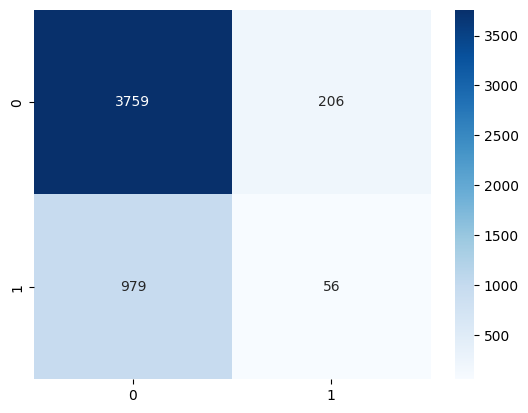

In [24]:
#混同行列
cm = confusion_matrix(pred_df['rank_prize'], pred_df['pred_rank_prize'])
sns.heatmap(cm, annot=True, cmap='Blues',fmt=".0f")

In [25]:
target_horse_query = '''
    SELECT * 
    FROM horse_dataset.target_horse_table 
    LIMIT 20
    '''
target_horse_df = client.query(target_horse_query).to_dataframe()

In [26]:
race_query = '''
    SELECT * 
    FROM race_dataset.target_race_table 
    LIMIT 1
    '''
target_race_df = client.query(race_query).to_dataframe()

In [31]:
#データのマージ
target_race_df_for_merge = target_race_df[['race_id',
                             "race_round",
                             "weather",
                             "ground_status",
                             "where_racecourse",
                             "total_horse_number",
                             "is_obstacle",
                             "ground_type",
                             "is_left_right_straight",
                             "distance",
                             "weather_rain",
                             "weather_snow",
                             "datetime"
                            ]]

merged_target_horse_df = pd.merge(target_horse_df, target_race_df_for_merge, on='race_id')

In [33]:
#エンコード
for column in [
               'weather',
               'where_racecourse',
               'ground_type',
               'is_left_right_straight']:
    le = LabelEncoder()
    le.fit(merged_target_horse_df[column])
    merged_target_horse_df[column] = le.transform(merged_target_horse_df[column])

In [38]:
#datetimeをUnix時間に変換してint32に変換する
unix_time = merged_target_horse_df['datetime'].astype('int64')
unix_time_int32 = unix_time.astype('int32')

merged_target_horse_df['datetime'] = unix_time_int32

In [39]:
#使う特徴量の設定
id = {"race_id",
      "horse_id"
    }

feature = [
#horse_df
           "race_id",
           "horse_id",
           "frame_number",
           "horse_number",
           "sex_and_age",
           "burden_weight",
           "rider_id",
           "horse_weight",
           "tamer_id",
#            "owner_id",
#            "is_down",
           "is_senba",
           "is_mesu",
           "is_osu",
           "horse_weight_dif",
#            "burden_weight_rate",
#race_df           
             "race_round",
             "weather",
             "ground_status",
             "where_racecourse",
             "total_horse_number",
             "is_obstacle",
             "ground_type",
             "is_left_right_straight",
             "distance",
             "weather_rain",
             "weather_snow",
             "datetime"
            ]

target = ['rank']

X_id = merged_target_horse_df[feature]
X = X_id.drop(id, axis =1)
#KeyError: "['owner_id', 'is_down', 'burden_weight_rate'] not in index"

In [43]:
X = X.astype(float)

In [46]:
train_baskets = X_train_id.groupby(["race_id"])["horse_id"].count().values
best_ranker = LGBMRanker(**best_params)
y = model.predict(X)

#結果を入れるデータフレームを用意
pred_df_fold = pd.DataFrame({
   "race_id": X_id['race_id'],
   "horse_id": X_id['horse_id'],
   "pred_rank": y
   })

pred_df_fold['rank'] = pred_df_fold['pred_rank'].rank(method='dense', ascending=False)

In [47]:
pred_df_fold

,race_id,horse_id,pred_rank,rank
0,202309011011,2020102890,-0.053886,13.0
1,202309011011,2020103530,0.001752,2.0
2,202309011011,2020100236,-0.037873,11.0
3,202309011011,2020100686,-0.039636,12.0
4,202309011011,2020104496,-0.060775,15.0
5,202309011011,2020101678,-0.086063,18.0
6,202309011011,2020103076,-0.016299,9.0
7,202309011011,2020110137,-0.002540,3.0
8,202309011011,2020100909,-0.003792,4.0
9,202309011011,2020101590,0.030030,1.0
